In [1]:
import torch
from torch import nn
from torch.nn import functional as F

from typing import Optional

from dataclasses import dataclass, replace
import numpy as np
import einops

from tqdm.notebook import tqdm

import time
import polars as pl

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


import torchopt


import matplotlib.pyplot as plt

In [2]:
torch.cuda.is_available()

True

In [75]:
from torch.nn.functional import relu

@dataclass
class Config:
  n_features: int
  n_hidden: int

  # We optimize n_instances models in a single training loop
  # to let us sweep over sparsity or importance curves 
  # efficiently.

  # We could potentially use torch.vmap instead.
  n_instances: int

 
class Model(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.W0 = nn.Parameter(torch.empty((config.n_hidden, config.n_features)))
        self.b_init = nn.Parameter(torch.zeros((config.n_hidden,), device=device))
        nn.init.xavier_normal_(self.W0)
        self.W1 = nn.Parameter(torch.empty((config.n_features, config.n_hidden)))
        nn.init.xavier_normal_(self.W1)
        


    def forward(self, features):
    # features: [..., instance, n_features]
    # W: [instance, n_features, n_hidden]
        hidden = torch.einsum('bi,hi->bh', features, self.W0) + self.b_init
        out = torch.einsum('bh,ih->bi', relu(hidden), self.W1)
        return out




class SparseUniformData:

    def __init__(self, n_instances, n_features, importance=None, feature_probability=None, device='cuda:0'):
        self.n_instances = n_instances
        self.n_features = n_features
        if feature_probability is None:
            feature_probability = torch.ones(())
        self.feature_probability = feature_probability.to(device)
        if importance is None:
            importance = torch.ones(())
        self.importance = importance.to(device)
        self.device = device
    
    def generate(self, n_batch):
        feat = torch.zeros((self.n_instances, n_batch, self.n_features), device=self.device).squeeze()
        feat.uniform_(-1, 1)
        batch = torch.where(
          torch.rand((self.n_instances, n_batch, self.n_features), device=self.device).squeeze() <= self.feature_probability,
          feat,
          torch.zeros((), device=self.device),
        )
        return batch



In [76]:
from torch.func import functional_call, stack_module_state
import copy

config = Config(
    n_features = 4,
    n_hidden = 2,
    n_instances = 1,
)

device = 'cuda:0'

model = Model(
    config=config,
    # Exponential feature importance curve from 1 to 1/100
    #importance = (0.9**torch.arange(config.n_features))[None, :],
    # Sweep feature frequency across the instances from 1 (fully dense) to 1/20
    #feature_probability = (20 ** -torch.linspace(0, 1, config.n_instances))[:, None]
)
model.to(device)

#models = [Model(config).to(device) for _ in range(config.n_instances)]

stream = SparseUniformData(
    config.n_instances,
    config.n_features,
    # Exponential feature importance curve from 1 to 1/100
    #importance = (0.9**torch.arange(config.n_features))[None, :],
    # Sweep feature frequency across the instances from 1 (fully dense) to 1/20
    feature_probability = torch.tensor(0.2)   #(20 ** -torch.linspace(0, 1, config.n_instances))[:, None, None]
)

#base_model = copy.deepcopy(models[0])
#base_model = base_model.to('meta')

#def fmodel(params, x):
#    return functional_call(base_model, (params,), (x,))
model(stream.generate(100))

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 8.0508e-01, -2.9350e-01,  9.1229e-03,  1.5904e-01],
        [ 1.8247e-01, -9.2906e-02, -5.6088e-02, -1.3026e-01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 2.0520e-01, -8.3162e-02, -1.6093e-02, -1.2135e-02],
        [ 2.2955e-02, -1.1688e-02, -7.0559e-03, -1.6387e-02],
        [ 3.1415e-02, -1.9162e-02, -1.6638e-02, -4.2391e-02],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 1.6670e-01, -5.1539e-02,  2.2242e-02,  9.1134e-02],
        [ 1.7544e-01, -7.1100e-02, -1.3758e-02, -1.0375e-02],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 2.0987e-01, -6.4885e-02,  2.8001e-02,  1.1473e-01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 2.0813e-02, -1.2695e-02, -1.1022e-02, -2.8084e-02],
        [ 7.6729e-02, -2.3722e-02,  1.0238e-02,  4.1947e-02],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        

In [73]:
from tqdm.notebook import trange


def linear_lr(step, steps):
    return (1 - (step / steps))

def constant_lr(*_):
    return 1.0

def cosine_decay_lr(step, steps):
    return np.cos(0.5 * np.pi * step / (steps - 1))

def optimize(model, stream, n_batch=1024, steps=10_000, print_freq=100, lr=1e-3, hooks=[]):
    cfg = model.config

    opt = torch.optim.AdamW(model.parameters(), lr=lr)

    start = time.time()
    with trange(steps) as run:
        for step in run:
            opt.zero_grad(set_to_none=True)
            batch = stream.generate(n_batch)
            out = model(batch)
            loss = ((batch.abs() - out) ** 2).mean(dim=1).sum()
            loss.backward()
            opt.step()
        
            if hooks:
                hook_data = dict(
                    model=model,
                    step=step, 
                    opt=opt,
                    error=error,
                    loss=loss,
                    lr=step_lr
                )
            for h in hooks:
              h(hook_data)
            if step % print_freq == 0 or (step + 1 == steps):
                run.set_postfix(
                    loss=loss.item() / cfg.n_instances,
                    lr=lr,
                )

In [74]:
config = Config(
    n_features = 10,
    n_hidden = 6,
    n_instances = 1,
)

model = Model(
    config=config,
    # Exponential feature importance curve from 1 to 1/100
    #importance = (0.9**torch.arange(config.n_features))[None, :],
    # Sweep feature frequency across the instances from 1 (fully dense) to 1/20
    #feature_probability = torch.tensor(0.1) #(20 ** -torch.linspace(0, 1, config.n_instances))[:, None]
)

stream = SparseUniformData(
    config.n_instances,
    config.n_features,
    # Exponential feature importance curve from 1 to 1/100
    importance = (0.9**torch.arange(config.n_features))[None, :],
    # Sweep feature frequency across the instances from 1 (fully dense) to 1/20
    feature_probability = torch.tensor(0.05)   #(20 ** -torch.linspace(0, 1, config.n_instances))[:, None, None]
)

model.to('cuda:0')

#batch = stream.generate(100)
#out = model(batch)


optimize(model, stream, n_batch=4096, steps=20_000)

  0%|          | 0/20000 [00:00<?, ?it/s]

tensor(13.3053, device='cuda:0', grad_fn=<SumBackward0>)

In [71]:
model.W0

Parameter containing:
tensor([[-8.4099e-05,  1.6878e-06, -1.5034e+00, -4.3521e-05,  1.9523e-04],
        [-1.4828e-04,  1.0427e+00, -1.2173e-04, -6.3594e-05,  2.5983e-04]],
       device='cuda:0', requires_grad=True)

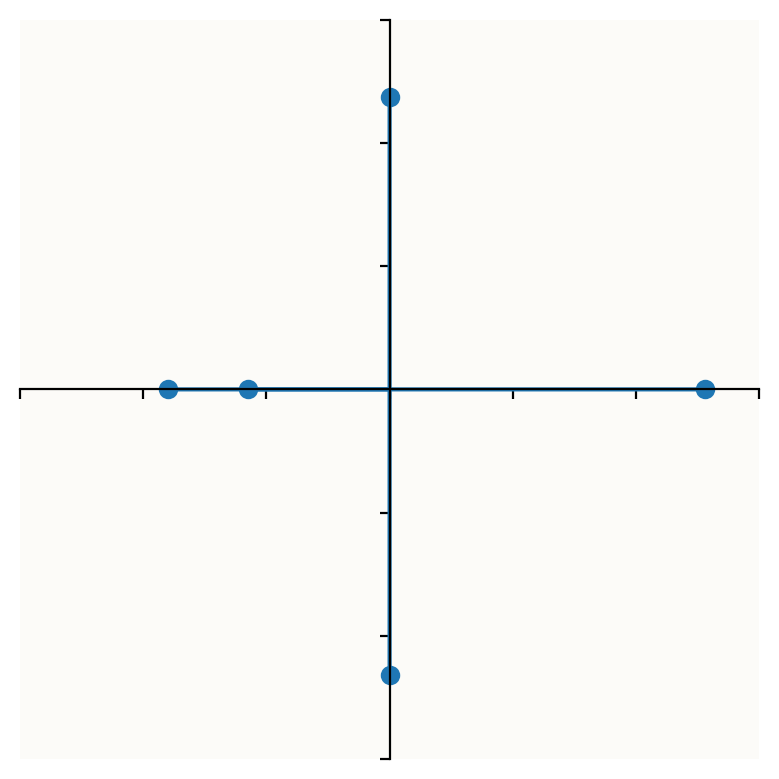

In [60]:
from matplotlib import colors  as mcolors
from matplotlib import collections  as mc

def plot_intro_diagram(model, stream):

    cfg = model.config
    W0_A = model.linear0.weight
    W1_A = model.linear1.weight
    N = len(W0_A[:,0])
    sel = range(config.n_instances) # can be used to highlight specific sparsity levels
    #plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis(stream.importance.cpu().numpy()))
    plt.rcParams['figure.dpi'] = 200
    fig, ax = plt.subplots()

    W = W0_A.cpu().detach().numpy()
    #colors = [mcolors.to_rgba(c)
    #    for c in plt.rcParams['axes.prop_cycle'].by_key()['color']]
    #ax.scatter(W[:,0], W[:,1], c=colors[0:len(W[:,0])])
    ax.scatter(W[:,0], W[:,1])
    ax.set_aspect('equal')
    #ax.add_collection(mc.LineCollection(np.stack((np.zeros_like(W),W), axis=1), colors=colors))
    ax.add_collection(mc.LineCollection(np.stack((np.zeros_like(W),W), axis=1)))
    
    z = 1.5
    ax.set_facecolor('#FCFBF8')
    ax.set_xlim((-z,z))
    ax.set_ylim((-z,z))
    ax.tick_params(left = True, right = False , labelleft = False ,
              labelbottom = False, bottom = True)
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    for spine in ['bottom','left']:
        ax.spines[spine].set_position('center')
    plt.show()

plot_intro_diagram(model, stream)

In [53]:
W = W0_A.cpu().detach().numpy()
W

array([[-3.3558461e-01, -7.0413970e-04],
       [ 1.0101963e-04,  9.9034435e-01],
       [ 3.1240564e-04, -7.4370539e-01],
       [-1.1632881e+00,  8.4953579e-05],
       [ 1.2330844e+00, -1.3950655e-04]], dtype=float32)

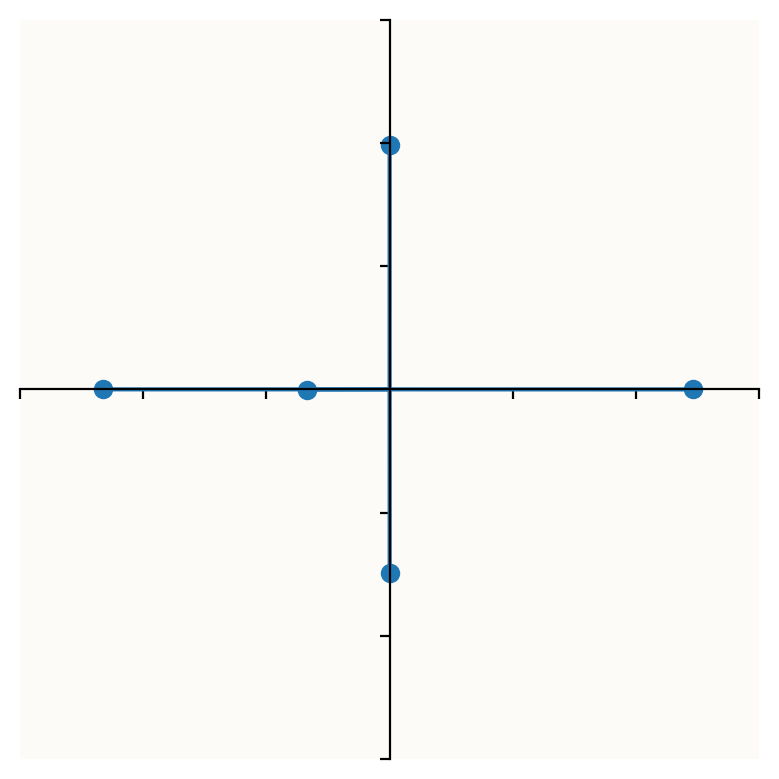

In [52]:
cfg = model.config
W0_A = model.linear0.weight
W1_A = model.linear1.weight
N = len(W0_A[:,0])
sel = range(config.n_instances) # can be used to highlight specific sparsity levels
#plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.viridis(stream.importance.cpu().numpy()))
plt.rcParams['figure.dpi'] = 200
fig, ax = plt.subplots()

W = W0_A.cpu().detach().numpy()
#colors = [mcolors.to_rgba(c)
#    for c in plt.rcParams['axes.prop_cycle'].by_key()['color']]
#ax.scatter(W[:,0], W[:,1], c=colors[0:len(W[:,0])])
ax.scatter(W[:,0], W[:,1])
ax.set_aspect('equal')
#ax.add_collection(mc.LineCollection(np.stack((np.zeros_like(W),W), axis=1), colors=colors))
ax.add_collection(mc.LineCollection(np.stack((np.zeros_like(W),W), axis=1)))

z = 1.5
ax.set_facecolor('#FCFBF8')
ax.set_xlim((-z,z))
ax.set_ylim((-z,z))
ax.tick_params(left = True, right = False , labelleft = False ,
          labelbottom = False, bottom = True)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
for spine in ['bottom','left']:
    ax.spines[spine].set_position('center')
plt.show()

In [34]:
W

array([[ 1.1052375e+00, -7.9472713e-02],
       [ 1.9320844e-01, -1.0739383e+00],
       [-9.9909025e-01, -4.6647742e-01],
       [ 2.8025672e-02, -2.2381398e-01],
       [-7.2942275e-01,  7.8876936e-01],
       [-9.5745077e-04,  1.6257060e-03],
       [-1.3350666e-04, -4.6174368e-04],
       [ 3.9898586e-01,  9.2390126e-01]], dtype=float32)

In [22]:
from torch.func import functional_call
import copy

# Construct a "stateless" version of one of the models. It is "stateless" in
# the sense that the parameters are meta Tensors and do not have storage.
base_model = copy.deepcopy(models[0])
base_model = base_model.to('meta')

def fmodel(params, x):
    return functional_call(base_model, (params,), (x,))

In [23]:
batch = generator.generate_batch(100)
fmodel(params, batch.unsqueeze(0))

RuntimeError: The size of tensor a (100) must match the size of tensor b (10) at non-singleton dimension 1

In [6]:

model(batch)

tensor([[0.3695, 0.0000, 0.0000,  ..., 0.2397, 0.4215, 0.2793],
        [0.1911, 0.0821, 0.0000,  ..., 0.3861, 0.9307, 0.4032],
        [0.2011, 0.0000, 0.0000,  ..., 0.0810, 0.0374, 0.0000],
        ...,
        [0.2143, 0.1500, 0.0000,  ..., 0.0679, 0.1889, 0.0056],
        [0.0772, 0.0897, 0.0000,  ..., 0.0863, 0.4066, 0.0000],
        [0.1200, 0.0000, 0.0000,  ..., 0.0259, 0.0352, 0.0371]],
       device='cuda:0', grad_fn=<ReluBackward0>)

In [ ]:
from torch.optim import AdamW
from tqdm.notebook import tqdm



def optimize(
    model, 
    n_batch=1024,
    steps=10_000,
    print_freq=100,
    lr=1e-3,
    lr_scale=constant_lr,
    hooks=[]
):
    cfg = model.config

    opt = AdamW(model.parameters(), lr=lr)

    for i in tqdm(range(steps)):
        for step in t:
            step_lr = lr * lr_scale(step, steps)
            for group in opt.param_groups:
                group['lr'] = step_lr
          opt.zero_grad(set_to_none=True)
      batch = model.generate_batch(n_batch)
      out = model(batch)
      error = (model.importance*(batch.abs() - out)**2)
      loss = einops.reduce(error, 'b i f -> i', 'mean').sum()
      loss.backward()
      opt.step()
    
   